# Fast SCNN

![Fast-SCNN Architecture](https://github.com/DeepVoltaire/Fast-SCNN/raw/master/figures/fast-scnn.png)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np

In [2]:
INPUT_SHAPE = (2048, 1024, 3)
N_CLASSES = 19

>### Conv

In [104]:
class Conv_Block(keras.Model):
    def __init__(self, filters, kernel_size=3, strides=2, padding='same', activation='relu', conv_type='sep_depthwise'):
        super(Conv_Block, self).__init__(name = 'Conv_Block')
        self.activation=activation
        if conv_type == 'conv':
            self.conv = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)
        elif conv_type == 'sep_depthwise':
            self.conv = layers.SeparableConv2D(filters, kernel_size, strides=strides, padding=padding)  #depthwise spatial conv + pointwise conv
        self.bn = layers.BatchNormalization()
        if activation:
            self.relu = keras.activations.relu 
            
        
    def call(self, inputs): 
        x = self.conv(inputs)
        x = self.bn(x)
        if self.activation:
            x = self.relu(x)
        return x

In [105]:
conv = Conv_Block(64, conv_type='sep_depthwise')
conv.build(input_shape=(None,)+INPUT_SHAPE)
inputs = keras.Input(shape=INPUT_SHAPE)
conv.call(inputs)
conv.summary()

<KerasTensor: shape=(None, 1024, 512, 64) dtype=float32 (created by layer 'tf.nn.relu_13')>

Model: "Conv_Block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_20 (Separab (None, 1024, 512, 64)     283       
_________________________________________________________________
batch_normalization_47 (Batc (None, 1024, 512, 64)     256       
Total params: 539
Trainable params: 411
Non-trainable params: 128
_________________________________________________________________


>### Bottleneck

In [112]:
class Resnet_Block(keras.Model):
    def __init__(self, in_filters, filters, strides, kernel_size=3, t=6, shortcut=False):
        super(Resnet_Block, self).__init__()
        self.shortcut = shortcut
        self.conv1 = Conv_Block(in_filters*t, kernel_size=1, strides=1, conv_type='conv')
        self.depthwise = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=strides, depth_multiplier=1, padding='same')
        self.bn = layers.BatchNormalization()
        self.relu = keras.activations.relu
        self.conv2 = Conv_Block(filters, kernel_size=1, strides=1, activation=None)

    def call(self, inputs): #(h,w,c1)
        x = self.conv1(inputs) #(h,w,c1*t)
        x = self.depthwise(x) #(h/s,w/s,c1*t)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x) #(h/s,w/s,c2)
        if self.shortcut:
            x = layers.add([x, inputs],name='shortcut')
        return x

In [93]:
res = Resnet_Block(64, 64, 2) 
res.build(input_shape=(None, 256, 128, 64))
inputs = keras.Input(shape=(256, 128, 64))
res.call(inputs)
res.summary()

<KerasTensor: shape=(None, 128, 64, 64) dtype=float32 (created by layer 'Conv_Block')>

Model: "Resnet_Block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_Block (Conv_Block)      (None, 256, 128, 384)     26496     
_________________________________________________________________
depthwise_conv2d_10 (Depthwi (None, 128, 64, 384)      3840      
_________________________________________________________________
batch_normalization_36 (Batc (None, 128, 64, 384)      1536      
_________________________________________________________________
Conv_Block (Conv_Block)      (None, 128, 64, 64)       25280     
Total params: 57,152
Trainable params: 55,488
Non-trainable params: 1,664
_________________________________________________________________


>### Pyramid Pooling

In [94]:
class Pyramid_Pooling_Block(keras.Model):
    def __init__(self, bin_size, h=64, w=32): #此时图片的shape应该为(64,32)
        super(Pyramid_Pooling_Block, self).__init__(name = 'Pyramid_Pooling_Block')
        self.pool = layers.AveragePooling2D((h//bin_size, w//bin_size), strides=(h//bin_size, w//bin_size))
        self.conv = layers.Conv2D(128, 3, 2, padding='same')
        self.resize = layers.Lambda(lambda x: tf.image.resize(x, (h,w)))
    
    def call(self, inputs):
        x = self.pool(inputs)
        x = self.conv(x)
        x = self.resize(x)
        return x
    
class Pyramid_Pooling(keras.Model):
    def __init__(self, bin_sizes):
        super(Pyramid_Pooling, self).__init__(name='Pyramid_Pooling')
        self.pool_blocks = []
        for bin_size in bin_sizes:
            self.pool_blocks.append(Pyramid_Pooling_Block(bin_size))
    
    def call(self, inputs):
        results = [inputs]
        for block in self.pool_blocks:
            x = block(inputs)
            results.append(x)
        x = layers.concatenate(results)
        return x 

In [95]:
pool = Pyramid_Pooling(BIN_SIZES)
pool.build(input_shape=(None,64, 32, 128))
inputs = keras.Input(shape=(64, 32, 128))
pool.call(inputs)
pool.summary()

<KerasTensor: shape=(None, 64, 32, 640) dtype=float32 (created by layer 'concatenate_4')>

Model: "Pyramid_Pooling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Pyramid_Pooling_Block (Pyram (None, 64, 32, 128)       147584    
_________________________________________________________________
Pyramid_Pooling_Block (Pyram (None, 64, 32, 128)       147584    
_________________________________________________________________
Pyramid_Pooling_Block (Pyram (None, 64, 32, 128)       147584    
_________________________________________________________________
Pyramid_Pooling_Block (Pyram (None, 64, 32, 128)       147584    
Total params: 590,336
Trainable params: 590,336
Non-trainable params: 0
_________________________________________________________________


>### SCNN

In [178]:
class SCNN(keras.Model):
    def __init__(self, n_classes = N_CLASSES):
        super(SCNN, self).__init__(name ='Fast_SCNN')
        # Downsample
        self.down1 = Conv_Block(32, conv_type='conv') #(1024, 512, 32)
        self.down2 = Conv_Block(48, conv_type='sep_depthwise') #(512, 256, 48)
        self.down3 = Conv_Block(64, conv_type='sep_depthwise') #(256, 128, 64)
        
        # Global Feature Extractor
        self.bottleneck1 = self.build_bottleneck(1, 64, 64, 2) #(128, 64, 64)
        self.bottleneck2 = self.build_bottleneck(2, 64, 96, 2) #(64, 32, 96)
        self.bottleneck3 = self.build_bottleneck(3, 96, 128, 1) #(64, 32, 128)
        self.pool = Pyramid_Pooling([2,4,6,8])  #(64, 32, 640)
        
        # Feature Fusion (down->fusion1, pool->fusion2)
        self.fusion1 = Conv_Block(128, kernel_size=1, strides=1, activation=None, conv_type='conv') #(256, 128, 128)
        self.fusion2 = keras.Sequential([
                            layers.UpSampling2D((4, 4)),  #(256, 128, 640)
                            layers.SeparableConv2D(128, 3, 1, padding='same', dilation_rate=4),  #(256, 128, 128)
                            layers.BatchNormalization(),
                            layers.Activation('relu'),
                            layers.Conv2D(128, 1, 1, padding='same')],name='fusion2') #(256, 128, 128) 
        self.fusion = keras.Sequential([layers.BatchNormalization(), layers.Activation('relu')])
        
        # Classifier
        self.classifier = keras.Sequential([
                            layers.SeparableConv2D(128, 3,1, padding='same', name='DSConv1_classifier'), #(256, 128, 128) 
                            layers.BatchNormalization(),
                            layers.Activation('relu'),
                            layers.SeparableConv2D(128, 3,1, padding='same', name = 'DSConv2_classifier'),
                            layers.BatchNormalization(),
                            layers.Activation('relu'),
                            Conv_Block(n_classes, kernel_size=1, strides=1, activation=None, conv_type='conv'), #(256, 128, 19)
                            layers.Dropout(0.3),
                            layers.UpSampling2D((8, 8)), #(2048,1024,19)
                            layers.Activation('softmax')], name='classifier')
    
    def build_bottleneck(self, idx, in_filters, filters, strides, n=3):
        bottleneck = keras.Sequential(name=f'bottleneck{idx}') 
        bottleneck.add(Resnet_Block(in_filters, filters, strides)) #64*t->filters
        for i in range(1, n): #filters->filters         
            bottleneck.add(Resnet_Block(filters, filters, strides=1, shortcut=True)) 
        return bottleneck
    
    def call(self, inputs):
        x = self.down1(inputs)
        x = self.down2(x)
        conv = self.down3(x)
        
        x = self.bottleneck1(conv)
        x = self.bottleneck2(x)
        x = self.bottleneck3(x)
        global_f = self.pool(x)
        
        f1 = self.fusion1(conv)
        f2 = self.fusion2(global_f)
        f = layers.add([f1, f2])
        f = self.fusion(f)
        
        x = self.classifier(f)         
        return x

In [179]:
fast_scnn = SCNN()
fast_scnn.build(input_shape=(None,)+INPUT_SHAPE)
inputs = keras.Input(shape=INPUT_SHAPE)
fast_scnn.call(inputs)
fast_scnn.summary()

<KerasTensor: shape=(None, 2048, 1024, 19) dtype=float32 (created by layer 'classifier')>

Model: "Fast_SCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_Block (Conv_Block)      (None, 1024, 512, 32)     1024      
_________________________________________________________________
Conv_Block (Conv_Block)      (None, 512, 256, 48)      2064      
_________________________________________________________________
Conv_Block (Conv_Block)      (None, 256, 128, 64)      3824      
_________________________________________________________________
bottleneck1 (Sequential)     (None, 128, 64, 64)       171456    
_________________________________________________________________
bottleneck2 (Sequential)     (None, 64, 32, 96)        314784    
_________________________________________________________________
bottleneck3 (Sequential)     (None, 64, 32, 128)       566400    
_________________________________________________________________
Pyramid_Pooling (Pyramid_Poo (None, 64, 32, 640)       59

In [25]:
# 下图是用函数而非subclass定义模型时的summary，能更仔细地把所有layer都显示出来
fast_scnn.summary()

Model: "Fast_SCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 2048, 1024,  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 1024, 512, 32 896         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_v2_12 (Batc (None, 1024, 512, 32 128         conv2d_4[0][0]                   
__________________________________________________________________________________________________
Relu_12 (TensorFlowOpLayer)     [(None, 1024, 512, 3 0           batch_normalization_v2_12[0][0]  
__________________________________________________________________________________________

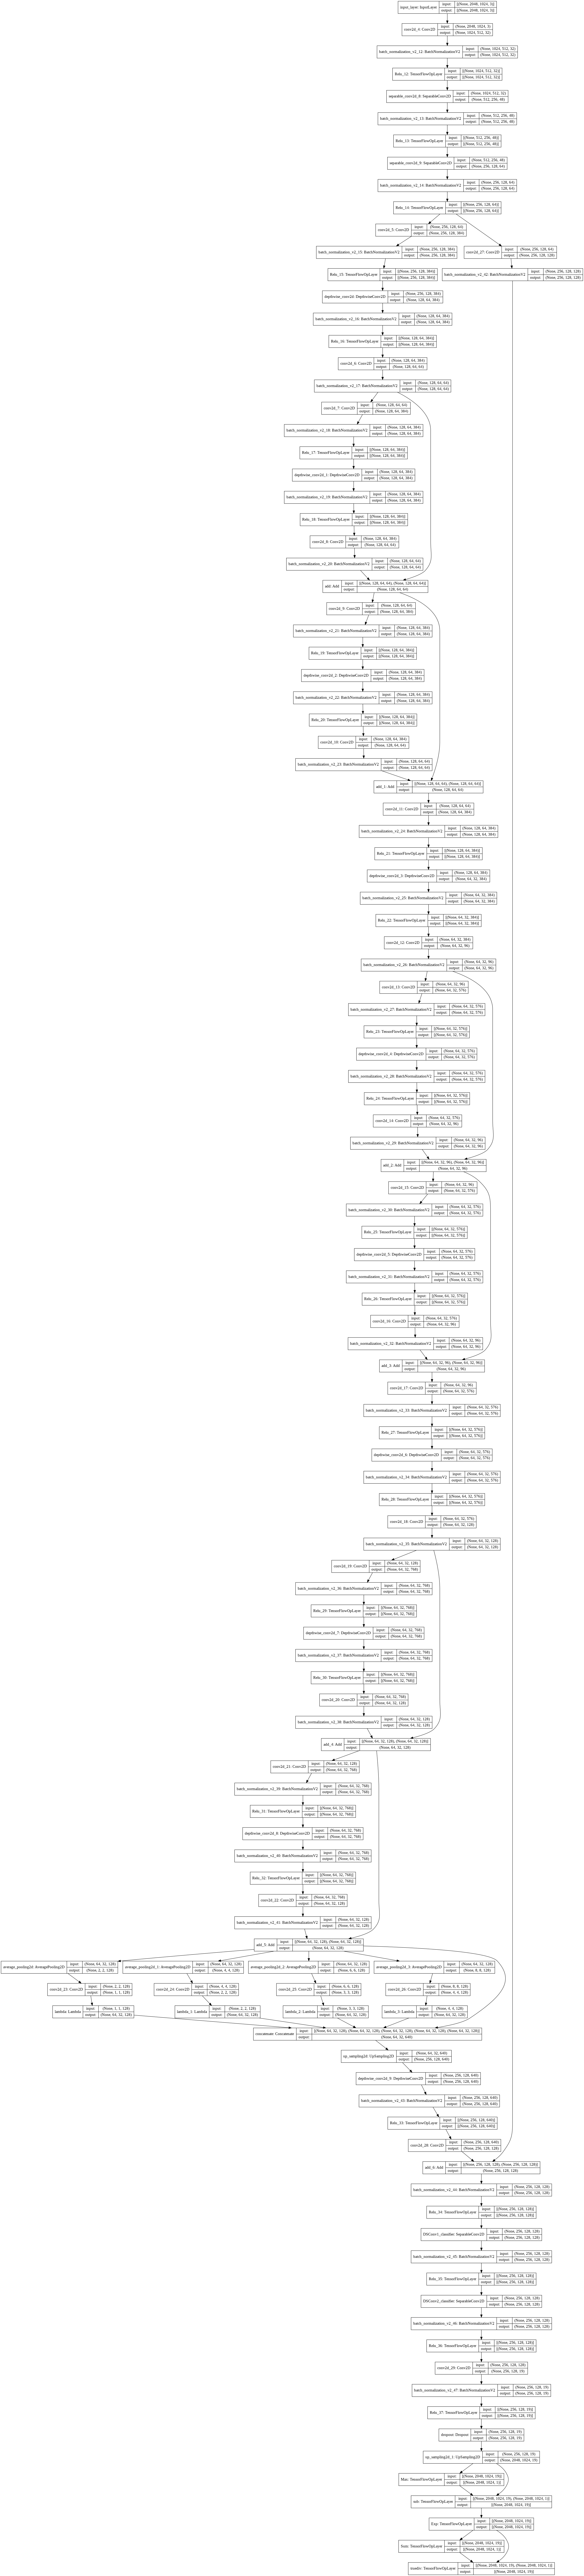

In [26]:
tf.keras.utils.plot_model(fast_scnn, show_layer_names=True, show_shapes=True)

> ### Compile

In [180]:
x = np.random.random((3, 2048, 1024, 3))
y = np.random.random((3, 2048, 1024))
y = tf.one_hot(y,depth=N_CLASSES)
data = tf.data.Dataset.from_tensor_slices((x,y)).batch(1)
data

<BatchDataset shapes: ((None, 2048, 1024, 3), (None, 2048, 1024, 19)), types: (tf.float64, tf.float32)>

In [181]:
fast_scnn.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.SGD(learning_rate=0.045, momentum=0.9),
              metrics=['accuracy'])
history = fast_scnn.fit(data, epochs=3)

Epoch 1/3
3/3 [==============================] - 22s 5s/step - loss: 3.5656 - accuracy: 0.0622
Epoch 2/3
3/3 [==============================] - 16s 6s/step - loss: 3.1925 - accuracy: 0.1101
Epoch 3/3
3/3 [==============================] - 14s 5s/step - loss: 2.5987 - accuracy: 0.2378
